In [18]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
import time
from matplotlib import pyplot as plt

In [19]:
housing_data = fetch_california_housing(as_frame=True)

In [20]:
df = housing_data.data
df['target'] = housing_data.target

In [21]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Linear function


In [22]:
def linear_one_feature(x, w, b):
  return w * x + b

In [23]:
def linear_multiple_features_non_vectorized(x, w, b):
  if len(w) != len(x):
    raise ValueError('the lengths of w and x_i must be the same')

  return sum(x[i] * w[i] for i in range(len(w))) + b

In [24]:
def linear_multiple_features(x, w, b):
  return np.dot(x, w) + b

In [25]:
def mse_non_vectorized(y_pred, y):
  return sum((y_pred[i] - y[i]) ** 2 for i in range(len(y))) / len(y)

In [26]:
def mse(y_pred, y):
  return np.mean((y_pred - y) ** 2)

In [75]:
def pred_non_vectorized(x, w, b):
  y_pred = []
  for i in range(len(x)):
    y_pred.append(linear_multiple_features(x[i], w, b))
  return y_pred

In [ ]:
def pred(x, w, b):
  return np.cross(x, w.T) + b

## Test previous functions


vectorized linear function is faster than using for loop with lists

In [28]:
size = 10000000
w = np.random.rand(size)
x = np.random.rand(size)
b = 15


tic = time.time()
non_vectorized_res = linear_multiple_features_non_vectorized(w.tolist(),
                                                              x.tolist(), b)
toc = time.time()
print(f'The non vectorized linear function with multiple features takes: {toc - tic}ms')
print(f'f(wx + b) = {non_vectorized_res}')

tic = time.time()
vectorized_res = linear_multiple_features(x, w, b)
toc = time.time()
print(f'The vectorized linear function with multiple features takes: {toc - tic}ms')
print(f'f(wx + b) = {vectorized_res}')


The non vectorized linear function with multiple features takes: 8.38385558128357ms
f(wx + b) = 2498933.0913590044
The vectorized linear function with multiple features takes: 0.015665054321289062ms
f(wx + b) = 2498933.091359015


vectorized mse is faster than using for loop with lists

In [45]:
y_pred = np.random.rand(size)
y = np.random.rand(size)

tic = time.time()
j_non_vectorized = mse_non_vectorized(y_pred.tolist(), y.tolist())
toc = time.time()
print(f'The non vectorized mse function takes: {toc - tic}ms')
print(f'J = {j_non_vectorized}')

tic = time.time()
j_vectorized = mse(y_pred, y)
toc = time.time()
print(f'The vectorized mse function takes: {toc - tic}ms')
print(f'J = {j_vectorized}')

The non vectorized mse function takes: 4.568714618682861ms
J = 0.16665137013349243
The vectorized mse function takes: 0.07773375511169434ms
J = 0.16665137013349768


## Gradient descent


In [65]:
def gradient_descent_non_vectorized(x, w, b, alpha, y, epochs=1000):

  m = len(x)
  n = len(w)

  cost_x = []
  num_x_seen = []
  if len(x[0]) != n:
    return ValueError("The number of features in x must be the same as the length of w")

  for epoch in range(epochs):
    gradient_w = [0] * n
    gradient_b = 0

    for i in range(m):
      y_pred = linear_multiple_features_non_vectorized(x[i], w, b)

      error = y_pred - y[i]

      for j in range(n):
        gradient_w[j] += error * x[i][j]

      gradient_b += error

    for j in range(n):
      w[j] -= alpha * gradient_w[j] / m
    b -= alpha * gradient_b / m

    y_pred_all = pred_non_vectorized(x, w, b)
    cost_x.append(mse_non_vectorized(y_pred_all, y))
    num_x_seen.append(epoch + 1)


  plt.figure(figsize=(10,5))
  plt.plot(num_x_seen, cost_x)
  plt.xlabel('epochs')
  plt.ylabel('Cost')
  plt.title('Cost vs Number of training examples seen')
  plt.grid()
  plt.show()

  return w, b

### gradient descent vectorized

In [81]:
def gradient_descent(x, w, b, alpha, y, epochs=1000):
  m = x.shape[0]
  n = w.shape[0]

  if x.shape[1] != n:
    return ValueError("The number of features in x must be the same as the length of w")

  cost_x = []
  num_epochs = []
  for epoch in range(epochs):
    y_pred = pred(x, w, b)
    error = y_pred - y

    gradient_w = np.dot(error.T, x) / m
    gradient_b = np.sum(error) / m

    w -= alpha * gradient_w
    b -= alpha * gradient_b

    cost_x.append(mse(y_pred, y))
    num_epochs.append(epoch + 1)

  plt.figure(figsize=(10,5))
  plt.plot(num_epochs, cost_x)
  plt.xlabel('epochs')
  plt.ylabel('Cost')
  plt.title('Cost vs Number of training examples seen')


  return w, b

# normalize data

In [69]:
def normalize(df):
  for col in df.columns:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
  return df

## train test split


In [49]:
def train_test_split_df(x, y, split = 0.1):
  train_size = int((1 - split) * len(x))
  x_train = x.values[:train_size]
  x_test = x.values[train_size:]
  y_train = y.values[:train_size]
  y_test = y.values[train_size:]
  return x_train, x_test, y_train, y_test

In [70]:
split = 0.2
df = df.sample(frac=1)

df = normalize(df)

x = df.iloc[:, :-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split_df(x, y, split)
n = x_train.shape[1]

# Train model

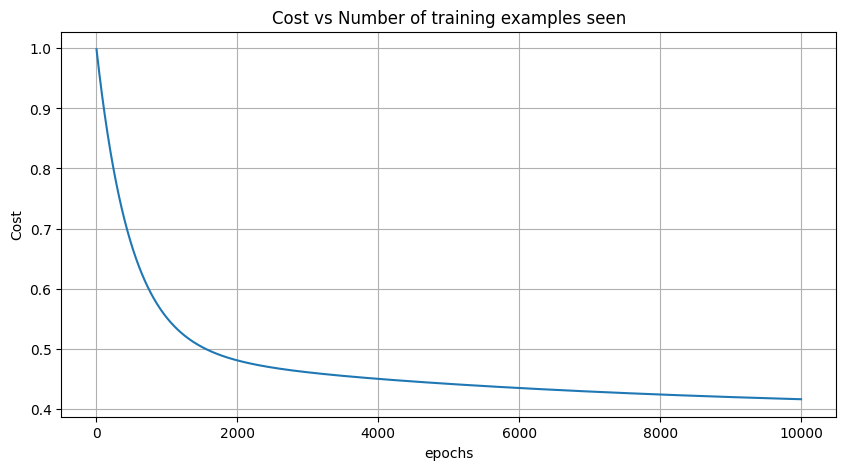

In [77]:
learning_rate = 0.001
w = [0] * n
b = 0
w, b = gradient_descent_non_vectorized(x_train.tolist(), w, b, learning_rate, y_train.tolist(), 10000)

In [78]:
print(mse_non_vectorized(pred_non_vectorized(x_train, w, b), y_train))
print(mse_non_vectorized(pred_non_vectorized(x_test, w, b), y_test))


0.41590892599275475
0.409191950048656


### vectorized

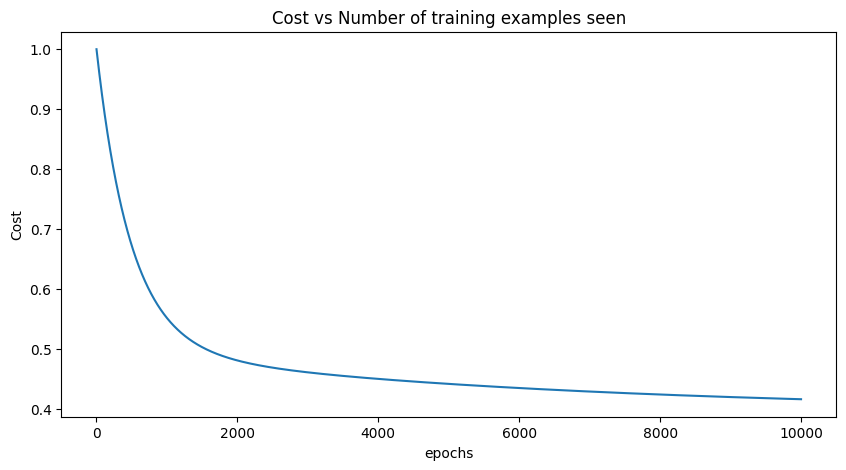

In [85]:
learning_rate = 0.001
w = np.zeros(n)
b = 0
w, b = gradient_descent(x_train, w, b, learning_rate, y_train, 10000)

In [86]:
print(mse_non_vectorized(pred(x_train, w, b), y_train))
print(mse_non_vectorized(pred(x_test, w, b), y_test))


0.41590892599275475
0.40919195004865594
